In [36]:
import sys 
sys.path.append('/Users/willknott/Desktop/DIS/coursework/pds/wdk24/src')
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1 signal

In [46]:
from generation import generate_from_total_pdf

true_params = {'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}
starting_params=true_params

N_events = 10000
dataset = generate_from_total_pdf(N_events)

h0_nll: -10297.089021268774, h1_nll: -10965.149231338853
True inf 0.0


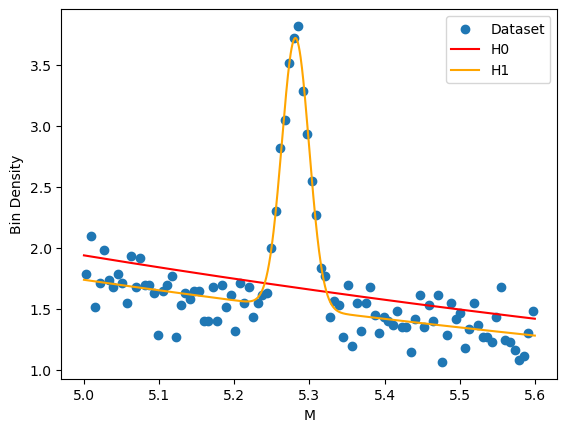

In [47]:
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test

starting_params={'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

fig, discovery, Z, p_value = signal_background_test(
                                dataset, 
                                pdf=total_pdf,
                                cdf=total_cdf, 
                                starting_params=starting_params,
                                binned=False,
                                plot=True
                                )

print(discovery, Z, p_value)

h0_nll: 12.670279948497624, h1_nll: 1.5239763361596537
False 3.140953854675945 0.000841992816020376


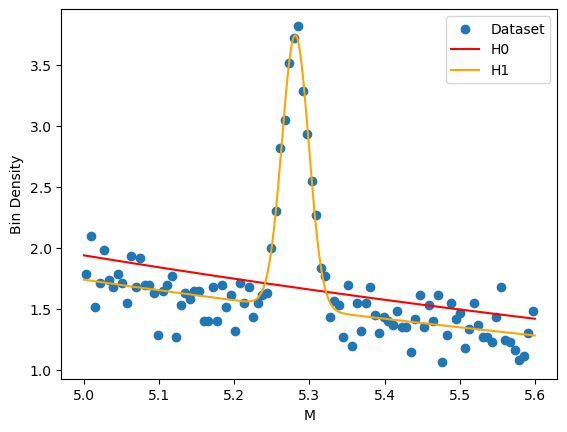

In [48]:
from distributions import total_cdf, total_pdf
from hypothesis_test import signal_background_test

starting_params={'f': 0.1, 'lam': 0.5, 'mu': 5.28, 'sigma': 0.018}

fig, discovery, Z, p_value = signal_background_test(
                                dataset, 
                                pdf=total_pdf,
                                cdf=total_cdf, 
                                starting_params=true_params,
                                binned=True,
                                plot=True
                                )

print(discovery, Z, p_value)

### 2 signal test

In [ ]:
from generation import generate_from_two_signal_pdf

starting_params = {'f1': 0.1, 'f2': 0.05, 'lam': 0.5, 'mu1': 5.28, 'mu2': 5.35, 'sigma': 0.018}

N_events = 2000
dataset = generate_from_two_signal_pdf(N_events)

True 5.592085290701825 1.1217927697870778e-08


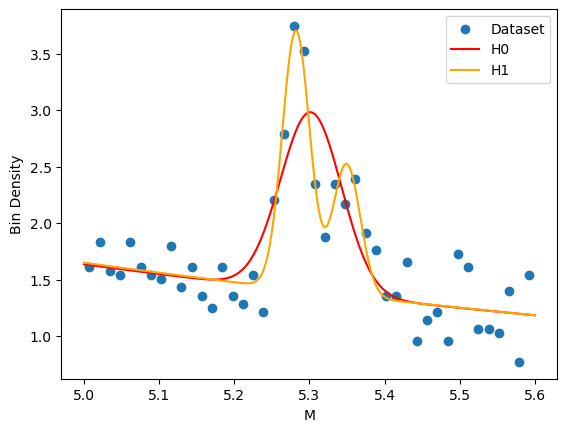

In [45]:
from hypothesis_test import two_signal_test
from distributions import two_signal_pdf, two_signal_cdf

fig, discovery, Z, p_value = two_signal_test(
                                dataset,
                                pdf=two_signal_pdf,
                                cdf=two_signal_cdf,
                                starting_params=starting_params,
                                binned=False,
                                plot=True
                                )

print(discovery, Z, p_value)

False 0.6535713325835009 0.2566940092868131


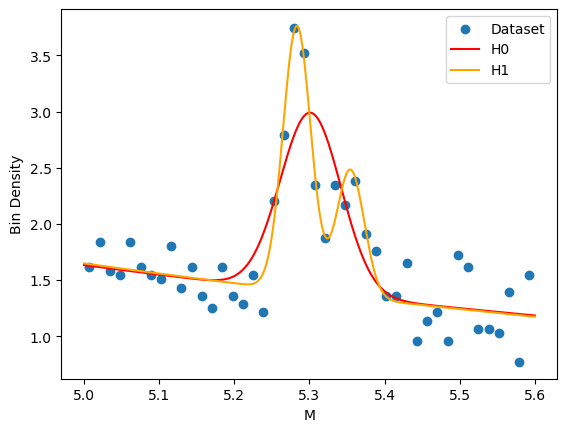

In [44]:
fig, discovery, Z, p_value = two_signal_test(
                                dataset,
                                pdf=two_signal_pdf,
                                cdf=two_signal_cdf,
                                starting_params=starting_params,
                                binned=True,
                                plot=True
                                )

print(discovery, Z, p_value)